### Import libraries

In [46]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Define Value class

In [196]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward =_backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def __rtruediv__(self, other):  # other / self
        return other * self**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### Functions to visualize the operations

In [48]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### One can nudge the data value of a node by h and check the gradient and apply that to the node's grad attribute

### What is backpropagation?
### - A recursive application of chain rule backwards through the computation graph

### Example code for a Neuron

In [77]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

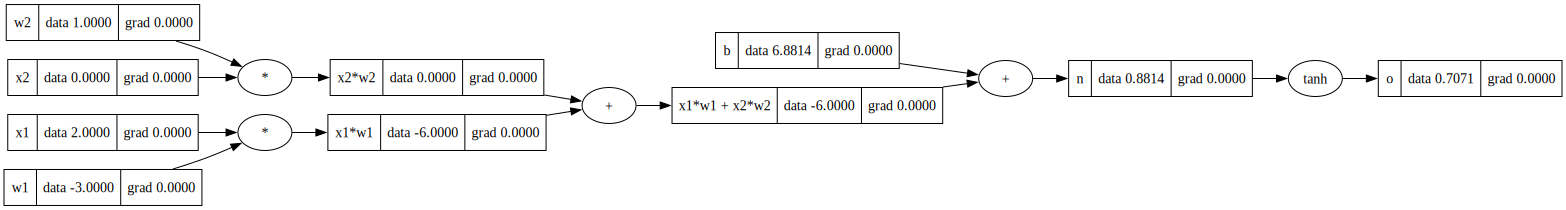

In [78]:
draw_dot(o)

In [79]:
o.backward()

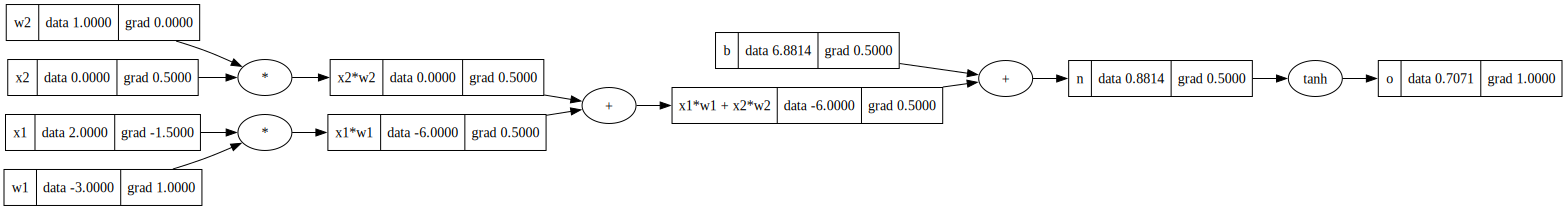

In [80]:
draw_dot(o)

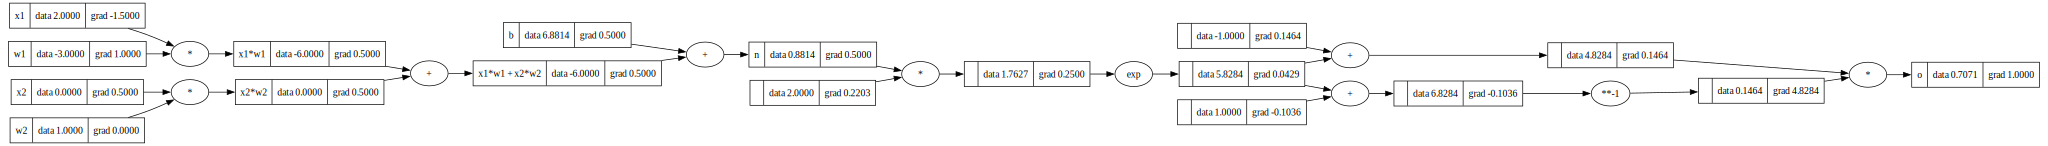

In [81]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

### Backprop in PyTorch

In [82]:
import torch

In [84]:
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [85]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

### Create Neuron class using our defined Value class

In [109]:
import random

In [132]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def paramaters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.paramaters()]

In [111]:
# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

In [143]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.04659837882051283)

In [144]:
n.parameters()

[Value(data=0.8210520604767033),
 Value(data=0.18107919537472528),
 Value(data=-0.49532870970384635),
 Value(data=0.5280184246466626),
 Value(data=-0.26296169541421044),
 Value(data=-0.5981103691901895),
 Value(data=0.518311752936254),
 Value(data=-0.28554588183060003),
 Value(data=-0.2202082655169466),
 Value(data=0.15271701923782355),
 Value(data=0.21954425198760785),
 Value(data=0.36755704603042494),
 Value(data=-0.795044755880308),
 Value(data=0.7878821684209301),
 Value(data=-0.6282659193602766),
 Value(data=0.5434841420144028),
 Value(data=0.4446024088921039),
 Value(data=-0.22771463227714728),
 Value(data=0.31509953525989154),
 Value(data=0.3052930203195918),
 Value(data=0.016141472980116145),
 Value(data=0.7129276147271784),
 Value(data=0.6085610948883973),
 Value(data=0.2096620672925995),
 Value(data=-0.5649268965926233),
 Value(data=-0.2688381071662078),
 Value(data=-0.619034905007688),
 Value(data=0.10204391695114068),
 Value(data=0.8439228730643626),
 Value(data=-0.15618180

In [145]:
# draw_dot(n(x))

### Tiny example dataset

In [158]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

In [176]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.00018081718433393985)

In [170]:
loss.backward()

In [171]:
n.layers[0].neurons[0].w[0].grad

-0.6402885427892129

In [172]:
n.layers[0].neurons[0].w[0].data

0.831585094593217

In [173]:
# draw_dot(loss)

In [174]:
for p in n.parameters():
    p.data -= 0.1 * p.grad

In [175]:
n.layers[0].neurons[0].w[0].data

0.8956139488721382

In [177]:
ypred

[Value(data=0.9956723308707458),
 Value(data=-0.9977028641906223),
 Value(data=-0.9886459274607584),
 Value(data=0.9947182703506754)]

### Proper training loop

In [192]:
# re initialize network
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

# set data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

In [193]:
for k in range(101):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update via gradient descent
    for p in n.parameters():
        p.data -= 0.1 * p.grad
    
    if k % 10 == 0:
        print(k, loss.data)

0 4.321138570963648
10 0.03703048576709943
20 0.017777648072060885
30 0.011462810529196607
40 0.008368092713464831
50 0.006548012360393735
60 0.005356650363834515
70 0.004519583833654103
80 0.003901004459106178
90 0.003426259672833552
100 0.003051023113564299


In [194]:
ypred

[Value(data=0.9694781607999073),
 Value(data=-0.9682975124998909),
 Value(data=-0.9827718263282761),
 Value(data=0.971406595801648)]

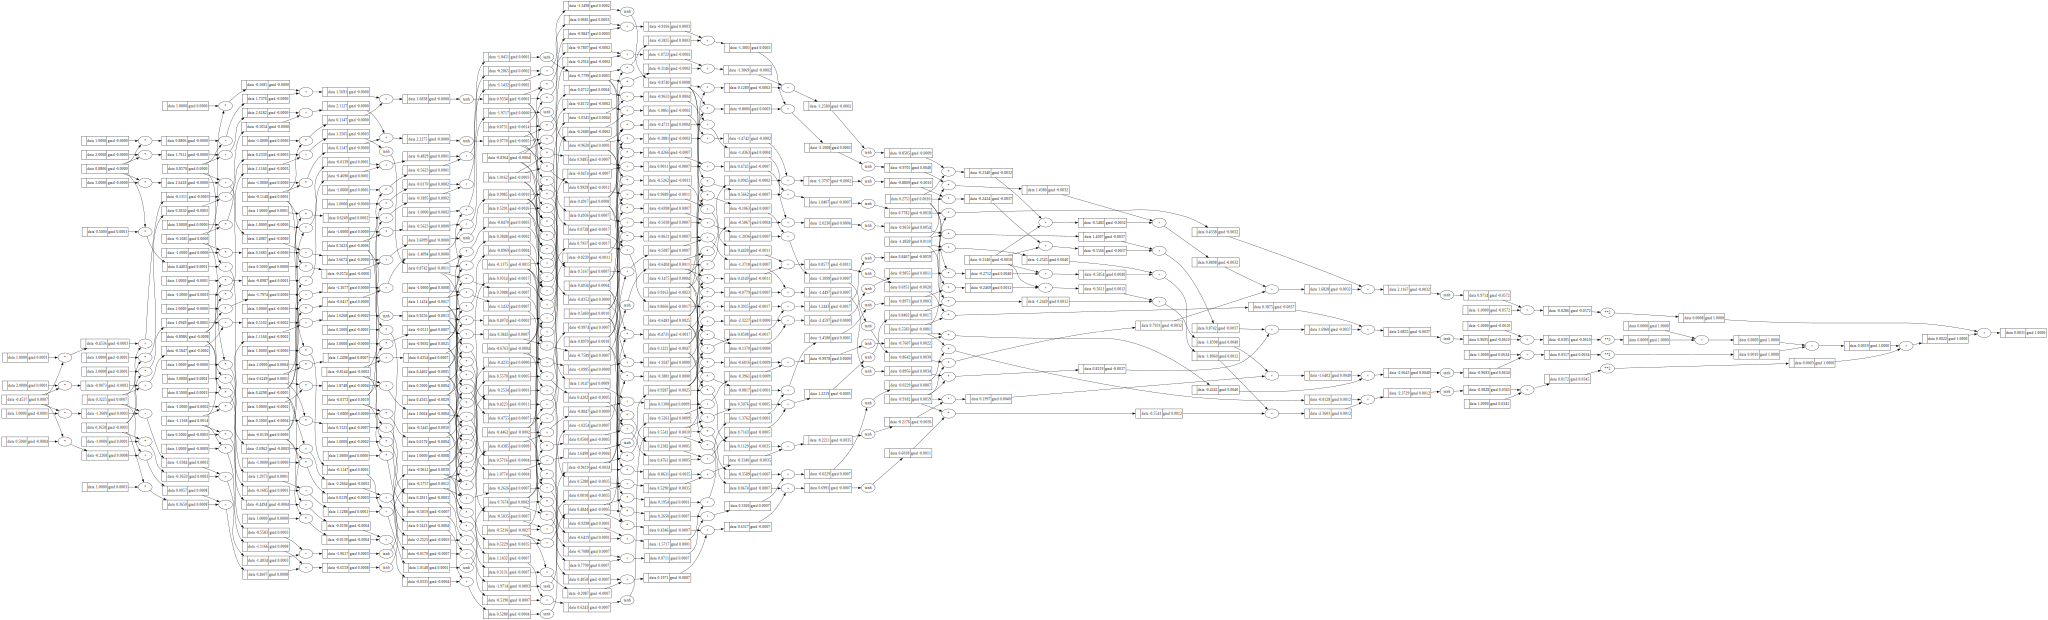

In [195]:
draw_dot(loss)